In [79]:
# !pip install numpy
# !pip install pyAgrum
# !pip install networkx
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

In [80]:
!pip list

Package           Version
----------------- -----------
asttokens         2.4.1
comm              0.2.2
contourpy         1.2.1
cycler            0.12.1
debugpy           1.8.1
decorator         5.1.1
exceptiongroup    1.2.1
executing         2.0.1
fonttools         4.51.0
ipykernel         6.29.4
ipython           8.23.0
jedi              0.19.1
joblib            1.4.2
jupyter_client    8.6.1
jupyter_core      5.7.2
kiwisolver        1.4.5
matplotlib        3.8.4
matplotlib-inline 0.1.7
mpmath            1.3.0
nest-asyncio      1.6.0
networkx          3.3
numpy             1.26.4
packaging         24.0
pandas            2.2.2
parso             0.8.4
pexpect           4.9.0
pillow            10.3.0
pip               24.0
platformdirs      4.2.1
prompt-toolkit    3.0.43
psutil            5.9.8
ptyprocess        0.7.0
pure-eval         0.2.2
pyAgrum           1.13.1
pydot             2.0.0
Pygments          2.17.2
pyparsing         3.1.2
python-dateutil   2.9.0.post0
pytz              20

In [81]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

# from data import DA_GenData, DA_Plot

# Data Generation process

In [82]:
# -----------------------------------------------------------------------------
# File    : data.py
# Created : 2024-04-18
# By      : TRILLA Alexandre (alexandre.trilla@alstomgroup.com)
#
# DiaLogs - Log Analytics
# -----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

def DA_GenData(N):
    """ Generate synthetic dataset for a 3 channel redundancy saftey system.
        
    Args:
        N (int): number of instances.

    Returns:
        data (numpy int tensor): [N,Time,Variable], [N,100,4].
            Variable: failure, ch1, ch2, ch3
        rc (numpy int array): Root causes: 1,2,3.
    """
    np.random.seed(42) 
    T = 100
    data = 0.05*np.random.randn(N,T,4)
    labels = np.random.random_integers(1,3,N)
    for n in range(N):
        for t in range(2,T):
            data[n,t,1] += 0.4*data[n,t-1,2] + 0.4*data[n,t-2,3] 
            data[n,t,2] += 0.4*data[n,t-1,1] + 0.4*data[n,t-1,3] 
            data[n,t,3] += 0.4*data[n,t-1,2] + 0.4*data[n,t-2,1] 
            if t > int(T/2):
                data[n,t,labels[n]] += 0.5*np.abs(np.random.randn())
            data[n,t,0] = np.min([1.0, np.abs(0.2*data[n,t,1] +\
                                             0.2*data[n,t,2] +\
                                             0.2*data[n,t,3])])
    data = (20*data+10).astype(int)
    data[:,:,0] -= 10
    for n in range(N):
        for t in range(T):
            if data[n,t,0] < 0:
                data[n,t,0] = 0
            if data[n,t,0] > 10:
                data[n,t,0] = 10
    return data,labels



def DA_Plot(data, labels):
    """ Plot dataset instance by instance.
        
    Args:
        data (numpy tensor): [N,Time,Variable]
        labels (numpy array): Root causes: 1,2,3.
    """
    datatime = np.arange(100)
    for i in range(data.shape[0]):
        plt.figure()
        plt.plot(datatime,data[i,:,0], 'k', label="Alarm Level")
        plt.plot(datatime,data[i,:,1], 'r', label="Channel 1")
        plt.plot(datatime,data[i,:,2], 'g', label="Channel 2")
        plt.plot(datatime,data[i,:,3], 'b', label="Channel 3")
        plt.legend(loc="upper left")
        plt.title("Failure on Channel: " + str(labels[i]))
        plt.xlabel("Time")
        plt.ylabel("Message Count")
        plt.show()

# Ground Truth Graph

In [83]:
""" 
ch1(t)  <- ch2(t-1)
        <- ch3(t-2)
ch2(t)  <- ch1(t-1)
        <- ch3(t-1)
ch3(t)  <- ch1(t-2)
        <- ch2(t-1)
alarm   <- ch1(t)
        <- ch2(t)
        <- ch3(t)
"""

G = nx.DiGraph()

nodes = ['alarm','ch1_t', 'ch2_t', 'ch3_t',  
         'ch1_t1', 'ch2_t1','ch3_t1',
         'ch1_t2', 'ch3_t2', 
        ]
# G.add_nodes_from()
for n in nodes:
    G.add_node(n)

G.add_edge('ch2_t1', 'ch1_t')
G.add_edge('ch3_t2', 'ch1_t')
G.add_edge('ch1_t1', 'ch2_t')
G.add_edge('ch3_t1', 'ch2_t')
G.add_edge('ch1_t2', 'ch3_t')
G.add_edge('ch2_t1', 'ch3_t')
G.add_edge('ch1_t','alarm')
G.add_edge('ch2_t','alarm')
G.add_edge('ch3_t','alarm')


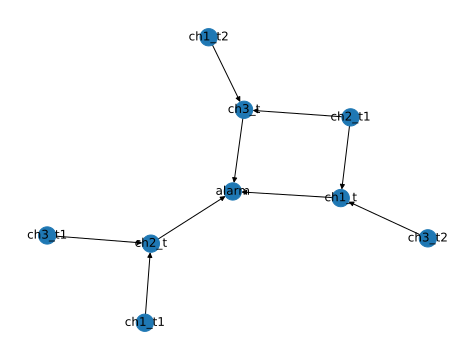

In [84]:
pos = nx.drawing.nx_pydot.graphviz_layout(G)
nx.draw(G,with_labels = True, pos=pos)

# Data Pre-Processing

In [85]:
#data pre-proc
def create_timelag_features(data):
    """
    Create time lag features for channels 1,2,3 
    """
    data_bn = np.zeros((data.shape[0], data.shape[1], 9))
    for i in range(data.shape[0]):
        data_occ = data[i]
        # generate lag column for all 3 channels
        dat_lag1 =  np.roll(data_occ[:,1:], shift=1, axis=0)
        dat_lag1[:1,:] = np.zeros(3)
        # generate 2 times lag column for ch1 & ch3
        dat_lag2 = np.roll(data_occ[:,[1,3]], shift=2, axis=0) 
        dat_lag2[:2,:] = np.zeros(2)
        data_bn[i] = np.hstack((data_occ, dat_lag1, dat_lag2))

    return data_bn

In [86]:
# Number of failure instances
n_inst = 120
# Generate synthetic data
data,labels = DA_GenData(n_inst)

# Split data into training and testing sets (100/20)
# Training data
train_data = data[:100]
train_labels = labels[:100]  
# Testing data
test_data = data[100:]
test_labels = labels[100:]

data_bn = create_timelag_features(train_data)
data_bn = data_bn.astype(int)

# Flatten the data set (3D -> 2D)
nrows = data_bn.shape[0] * data_bn.shape[1]
ncols = data_bn.shape[2]
data_flat = data_bn.reshape((nrows, ncols))
# Load it into data frame
df = pd.DataFrame(data=data_flat, columns=nodes)
df.head()

/tmp/ipykernel_1202/3176658547.py:26: DeprecationWarning: This function is deprecated. Please call randint(1, 3 + 1) instead
  labels = np.random.random_integers(1,3,N)


,alarm,ch1_t,ch2_t,ch3_t,ch1_t1,ch2_t1,ch3_t1,ch1_t2,ch3_t2
0,0,9,10,11,0,0,0,0,0
1,0,9,11,10,9,10,11,0,0
2,0,11,9,10,9,11,10,9,11
3,0,8,9,9,11,9,10,9,10
4,0,9,8,8,8,9,9,11,10


# Bayesian Network

## Modelling

In [87]:

gum.about()
gnb.configuration()


pyAgrum 1.13.1
(c) 2015-2023 Pierre-Henri Wuillemin, Christophe Gonzales

    This is free software; see the source code for copying conditions.
    There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  For details, see 'pyAgrum.warranty'.
    


Library,Version
OS,posix [linux]
Python,"3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]"
IPython,8.23.0
Matplotlib,3.8.4
Numpy,1.26.4
pyDot,2.0.0
pyAgrum,1.13.1


In [88]:
def get_range(df):
    desc = df.describe()
    desc = desc.loc[['min','max'],:].astype(int)
    desc.loc['min']=0
    return desc.to_dict('list')


  - alarm:Range([0,10])
  - ch1_t:Range([0,56])
  - ch1_t1:Range([0,56])
  - ch1_t2:Range([0,56])
  - ch2_t:Range([0,58])
  - ch2_t1:Range([0,58])
  - ch3_t:Range([0,56])
  - ch3_t1:Range([0,56])
  - ch3_t2:Range([0,56])


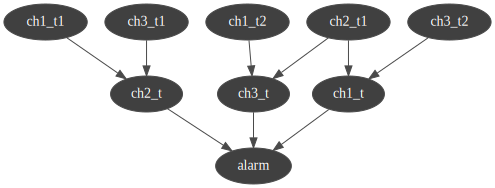

In [89]:
# Define Causal Structure
ranges = get_range(df)
dot_graph = f""" ch1_t{ranges['ch1_t']} -> alarm{ranges['alarm']};
ch2_t{ranges['ch2_t']} -> alarm{ranges['alarm']};
ch3_t{ranges['ch3_t']} -> alarm{ranges['alarm']};
ch1_t1{ranges['ch1_t1']} -> ch2_t{ranges['ch2_t']};
ch2_t1{ranges['ch2_t1']} -> ch1_t{ranges['ch1_t']};
ch2_t1{ranges['ch2_t1']} -> ch3_t{ranges['ch3_t']};
ch3_t1{ranges['ch3_t1']} -> ch2_t{ranges['ch2_t']};
ch1_t2{ranges['ch1_t2']} -> ch3_t{ranges['ch3_t']};
ch3_t2{ranges['ch3_t2']} -> ch1_t{ranges['ch1_t']}
"""
bn = gum.fastBN(dot_graph)
for v in sorted(bn.names()):
    print(f"  - {bn.variable(v)}")
gnb.showBN(bn,size=20)

  - alarm:Range([0,10])
  - ch1_t:Range([0,56])
  - ch1_t1:Range([0,56])
  - ch1_t2:Range([0,56])
  - ch2_t:Range([0,58])
  - ch2_t1:Range([0,58])
  - ch3_t:Range([0,56])
  - ch3_t1:Range([0,56])
  - ch3_t2:Range([0,56])


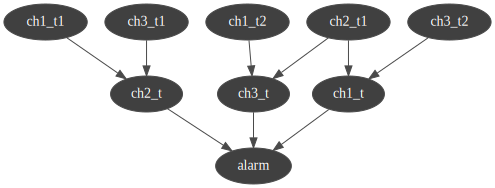

In [90]:
learner = gum.BNLearner(df,bn)
learner.useBDeuPrior()
bn2 = learner.learnParameters(bn)
for v in sorted(bn2.names()):
    print(f"  - {bn2.variable(v)}")

gnb.showBN(bn2,size=20)

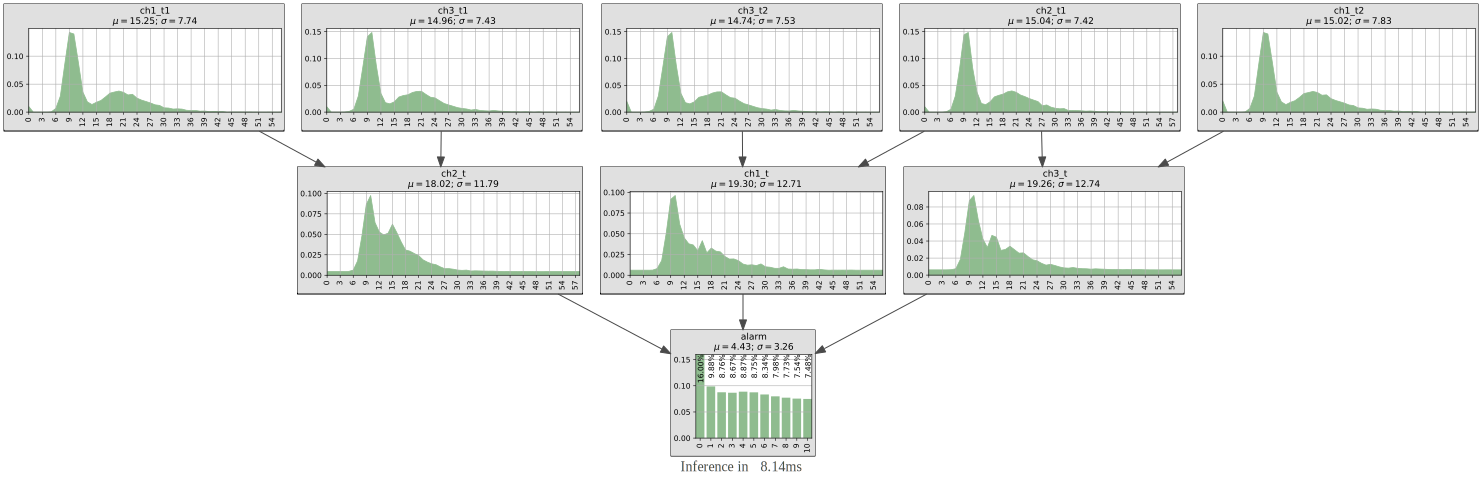

In [91]:
gnb.showInference(bn2, size=25)

In [92]:
# print("* by default, type induction is on (True) :")
# learner=gum.BNLearner(df)

# # add mandatory knowledges
# learner.addMandatoryArc('ch2_t1', 'ch1_t')
# learner.addMandatoryArc('ch3_t2', 'ch1_t')
# learner.addMandatoryArc('ch1_t1', 'ch2_t')
# learner.addMandatoryArc('ch3_t1', 'ch2_t')
# learner.addMandatoryArc('ch1_t2', 'ch3_t')
# learner.addMandatoryArc('ch2_t1', 'ch3_t')
# learner.addMandatoryArc('ch1_t','alarm')
# learner.addMandatoryArc('ch2_t','alarm')
# learner.addMandatoryArc('ch3_t','alarm')

# bn3=learner.learnBN()
# for v in sorted(bn3.names()):
#     print(f"  - {bn3.variable(v)}")

# # print("")
# # print("* but you can disable it :")
# # learner=gum.BNLearner(df,["?"],False)
# # bn3=learner.learnBN()
# # for v in sorted(bn3.names()):
# #     print(f"  - {bn3.variable(v)}")

# # print("")
# # print("Note that when a Labelized variable is found, the labesl are alphabetically sorted.")

# bn3

# Inference
## Failure Probability

In [93]:
def infer_target_probability(bn, input, labels, target:str):
    ie=gum.LazyPropagation(bn)
    evidence = {labels[k]:int(input[k])  for k in range(len(input))}
    ie.setEvidence(evidence)
    ie.makeInference()
    return ie.posterior(target) # 0 is index of failure event

def infer_expected_value(bn, input, labels, target):
    # Inference
    alm=bn[target]
    exp_vals_all = list()
    for window in input:
        exp_vals=list()
        for obs in window:
            # print(obs)
            pot = infer_target_probability(bn,obs[1:],labels[1:],target)
            exp_vals.append(pot.expectedValue(lambda v: alm.numerical(v[target])))
        exp_vals_all.append(exp_vals)

    return exp_vals_all

def plot_alarm(actual, predicted, w_id):
    time = range(actual.shape[1])
    # for i in range(actual.shape[0]):
    plt.plot(time,predicted[w_id], label='Predicted Alarm level', linewidth=7.0, alpha=0.5 )
    plt.plot(time,actual[w_id,:,0], label='Actual Alarm level')
    plt.xlabel("Time")
    plt.ylabel("Alarm level")
    plt.legend(loc='upper left')
    plt.title('Evolution of alarm over time')
    plt.show()

def infer_target_distribution(bn,input,w_id,labels,target):
    target_dist = list()
    for window in input[w_id]:
        for obs in window:
            pot = infer_target_probability(bn,obs[1:],labels[1:],target)
            target_dist.append(pot.tolist())

    return np.array(target_dist)

def plot_alarm_distribution(distro):
    im = plt.imshow(distro.T, origin='lower', cmap='plasma', aspect='auto')
    plt.xlabel('time')
    plt.ylabel('Alarm Levels')
    plt.colorbar(im)
    plt.show()

# def search_all_paths(cg, ind_labs, src, trg):
#     lab_inds = dict((v,k) for k,v in ind_labs.items())
#     # Convert to nx graph model
#     cg.to_nx_graph()
#     paths = []
#     for path in nx.all_simple_paths(cg.nx_graph, source=lab_inds[src], target=lab_inds[trg]):
#         paths.append([ind_labs[p] for p in path])
#         # print(path)
#     return paths


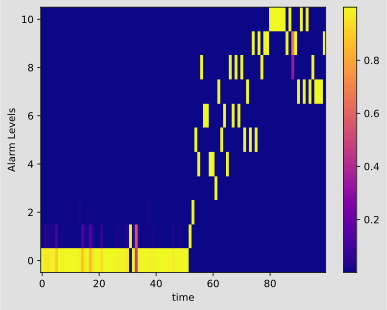

In [94]:
# make inference on training data and plot distribution.
alam_dist = infer_target_distribution(bn2, data_bn, [1], nodes, nodes[0])
plot_alarm_distribution(alam_dist)

### Inference on training data

In [95]:
# compute expected values of alarm for all the windows in input
train_alarm_pred = infer_expected_value(bn2, data_bn, nodes, nodes[0])

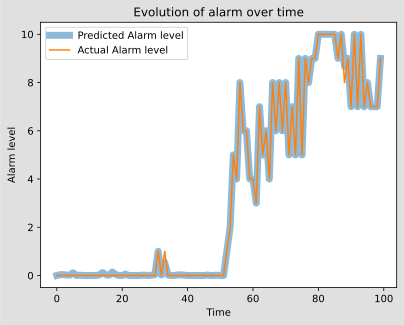

In [96]:
# plot predicted vs actual alarm values for inputdata w_id=1
plot_alarm(data_bn,train_alarm_pred,1)

### Inference on test data

In [97]:
# dat,labs = DA_GenData(5)
test_data_bn = create_timelag_features(test_data)
test_alarm_pred = infer_expected_value(bn2, test_data_bn, nodes, nodes[0])

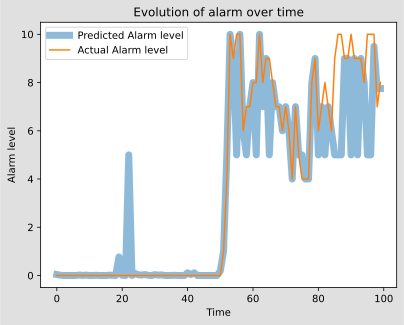

In [98]:
plot_alarm(test_data,test_alarm_pred,3)

## Point of Incipient failure

In [99]:
y = test_alarm_pred[1]
dy = np.diff(y)
dy=np.append(dy,np.nan)
ddy = np.diff(dy)
ddy = np.append(ddy,np.nan)
t = range(0,100)

In [100]:
np.array(y).shape,dy.shape, ddy.shape

((100,), (100,), (100,))

In [101]:
# len(t)

# t = t[45:60]
# y = y[45:60]
# dy = dy[45:60]
# ddy = ddy[45:60]

Text(0, 0.5, 'Alarm level')

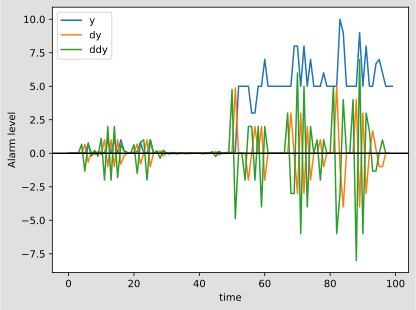

In [102]:
plt.plot(t,y,label='y')
plt.plot(t,dy,label='dy')
plt.plot(t,ddy,label='ddy')
plt.legend(loc='upper left')
plt.axhline(y=0, color='k')
plt.xlabel('time')
plt.ylabel('Alarm level')
# plt.axvline(x=0, color='k')


## Most likely path

In [103]:
def search_all_paths(graph, src, trg):
    """
    Searches for all paths between two nodes in a graph.

    Parameters:
    - cg (Graph): The graph object representing the causal graph.
    - ind_labs (dict): A dictionary mapping node indices to labels.
    - src (str): The label of the source node.
    - trg (str): The label of the target node.

    Returns:
    - paths (list): A list of lists, where each inner list represents a path between the source and target nodes.
    """
    # lab_inds = dict((v,k) for k,v in ind_labs.items())
    paths = []
    # for path in nx.all_simple_paths(graph, source=lab_inds[src], target=lab_inds[trg]):
    for path in nx.all_simple_paths(graph, source=src, target=trg):
        paths.append([p for p in path])
        # print(path)
    return paths

def find_root_nodes(graph):
    """
    Finds the root nodes of a directed graph.

    Parameters:
    - graph (Graph): The graph object.

    Returns:
    - root_nodes (list): A list of the root nodes.
    """
    root_nodes = [node for node, in_degree in graph.in_degree() if in_degree == 0]
    return root_nodes


def evaluate_path_likelihoods(bn, cg, data_pif, events, final_cfg):
    """
    Evaluates the likelihood of all paths in the causal graph.

    Parameters:
    - bn (BayesianNetwork): The Bayesian network object.
    - cg (CausalGraph): The causal graph object.
    - data_pif (list): The data in the PIF format.
    - events (list): The list of event labels.
    - idx_events (dict): A dictionary mapping event labels to indices.
    - final_cfg (dict): The final configuration.

    Returns:
    - path_probs (dict): A dictionary containing the paths and their probabilities.
    """
    # root causes are root nodes of the graph. 
    # i.e node with no parents/ancestors
    rcs = find_root_nodes(cg)

    paths = list()
    probs = list()
    path_probs = dict()
    for rc in rcs:
        for p in search_all_paths(cg, src=rc, trg=final_cfg['fail_event']):
            evids = {x:int(y) for x,y in zip(events, data_pif) if x not in p}
            path_value = {x:int(y) for x,y in zip(events, data_pif) if x in p}
            ie=gum.LazyPropagation(bn)
            ie.addJointTarget(set(p))
            ie.setEvidence(evids)
            ie.makeInference()
            # Infer joint probability of variables in path
            infer_cpt = ie.jointPosterior(set(p))   
            # Infering probability of path
            I = gum.Instantiation(infer_cpt)
            I[final_cfg['fail_event']]=1
            for k in path_value:
                I[k] = path_value[k]
            pf = infer_cpt.get(I)
            paths.append(p)
            probs.append(pf)
    
    # sort paths in decending order of probability
    idxs = np.argsort(probs)
    idxs = idxs[::-1]   # argsort sorts ascending, so filp the order
    path_probs = {
        'paths': [paths[i] for i in idxs],'probs': [round(probs[i],4) for i in idxs]
    }

    return path_probs


In [104]:
root_nodes = find_root_nodes(G)
print(f"MLP on training data. Alarm Channel={train_labels[1]}")
print(evaluate_path_likelihoods(bn2, G, data_bn[1,50,:], nodes, {'fail_event':'alarm'}))
print(f"MLP on testing data. Alarm Channel={test_labels[7]}")
print(evaluate_path_likelihoods(bn2, G, test_data_bn[7,50,:], nodes, {'fail_event':'alarm'}))

MLP on training data. Alarm Channel=1
{'paths': [['ch2_t1', 'ch1_t', 'alarm'], ['ch3_t2', 'ch1_t', 'alarm'], ['ch2_t1', 'ch3_t', 'alarm'], ['ch3_t1', 'ch2_t', 'alarm'], ['ch1_t2', 'ch3_t', 'alarm'], ['ch1_t1', 'ch2_t', 'alarm']], 'probs': [0.0558, 0.0523, 0.0418, 0.0243, 0.018, 0.015]}
MLP on testing data. Alarm Channel=2
{'paths': [['ch1_t1', 'ch2_t', 'alarm'], ['ch3_t1', 'ch2_t', 'alarm'], ['ch2_t1', 'ch3_t', 'alarm'], ['ch2_t1', 'ch1_t', 'alarm'], ['ch1_t2', 'ch3_t', 'alarm'], ['ch3_t2', 'ch1_t', 'alarm']], 'probs': [0.0435, 0.0428, 0.0331, 0.0208, 0.0086, 0.0074]}


In [105]:
# gnb.showBN(bn2,size=20)

## CounterFactual

Goal: illustrate the impact of time on RCA for predicitve maintenance
Data: time series of 3-channel safety system (2oo3), point of incipient 
      failure (PoIF) occurs at half the timeline, one channel randomly fails
 
 
Obj 1: discover structure using time-series approach (PC-MCI with 2 lags).
       Need explicit time to break the cycles.
 
For one example (illustrative purpose only):

Obj 2: show how the observed alarm level can be predicted.
       Need to pinpoint the PoIF (alarm level starts to rise).

Obj 3: show how the direct (concurrent) path is more likely than the 
       indirect (lagged) paths. For the root-cause channel RCC and another
       non-root-cause channel NRCC:
       
       1) RCC -> Alarm
       2) RCC -> RCC(t-1) -> NRCC -> Alarm
       3) RCC -> RCC(t-1) -> RCC(t-2) -> NRCC -> Alarm

Obj 4: show how a counterfactual on the likely root cause channel (avg value)
       reduces alarm level at the PoIF (before it propagates to the other
       channels). Compare with counterfactuals on other channels.
 
 
Outline issues for the workshop discussion:
- Alarm is a binary flag/delta. -> Augment with rise-time based on experience
- Message aggregation on templates.
- Others...

### Graph structure

In [106]:
# Define Causal Structure
# cf_graph = dot_graph + """;
# u_ch1_t[0,20]->ch1_t[0,56];
# u_ch2_t[0,20]->ch2_t[0,58];
# u_ch3_t[0,20]->ch3_t[0,56];
# u_ch1_t1[0,20]->ch1_t1[0,56];
# u_ch2_t1[0,20]->ch2_t1[0,58];
# u_ch3_t1[0,20]->ch3_t1[0,56];
# u_ch1_t2[0,20]->ch1_t2[0,56];
# u_ch3_t2[0,20]->ch3_t2[0,56];
# u_alarm[0,5]->alarm[0,10];
# """

# cf_bn = gum.fastBN(cf_graph)
# for v in sorted(cf_bn.names()):
#     print(f"  - {cf_bn.variable(v)}")
    
# gnb.showBN(cf_bn,size=20)

In [107]:
# Generating data for noise variables and adding to the data frame
df['u_ch1_t'] = np.random.uniform(0,21,df.shape[0]).astype(int)
df['u_ch2_t'] = np.random.uniform(0,21,df.shape[0]).astype(int)
df['u_ch3_t'] = np.random.uniform(0,21,df.shape[0]).astype(int)
df['u_ch1_t1'] = np.random.uniform(0,21,df.shape[0]).astype(int)
df['u_ch2_t1'] = np.random.uniform(0,21,df.shape[0]).astype(int)
df['u_ch3_t1'] = np.random.uniform(0,21,df.shape[0]).astype(int)
df['u_ch1_t2'] = np.random.uniform(0,21,df.shape[0]).astype(int)
df['u_ch3_t2'] = np.random.uniform(0,21,df.shape[0]).astype(int)
df['u_alarm'] = np.random.uniform(0,6,df.shape[0]).astype(int)

### BN Training

In [108]:
# cf_learner = gum.BNLearner(df,cf_bn)
# cf_learner.useBDeuPrior()
# cf_bn2 = cf_learner.learnParameters(cf_bn)
# for v in sorted(cf_bn2.names()):
#     print(f"  - {cf_bn2.variable(v)}")

# gnb.showBN(cf_bn2,size=20)

In [109]:
# gnb.showInference(cf_bn2, size=50)

### Counterfactual analysis

In [110]:
def do_counterfactual(cm, obs, cf_var, cf_val, trg):
    # print(f"Counterfactual on {cf_var}={cf_val}")
    pot=csl.counterfactual(cm =cm,
                    profile = obs, 
                    whatif={cf_var},
                    on={trg},
                    values = {cf_var : cf_val})

    return pot

def plot_cf_impact_on_trg(cm, obs, cf_var, trg):
    bn= cm.observationalBN()
    domain = list(map(int, bn.variable(cf_var).domain()[1:-1].split(',')))
    dom = [*range(domain[0],domain[1]+1)]
    trg_est = list()
    for i in dom:
        pot1 = do_counterfactual(cm, obs, cf_var, i, trg)
        trg_est.append(pot1.expectedValue(lambda v : bn.variable(trg).numerical(v[trg])))

    plt.plot(dom,trg_est)
    plt.xlabel(cf_var)
    plt.ylabel(trg)
    plt.axvline(obs[cf_var],color='r', label=f"Observed value of {cf_var }")
    plt.legend(loc='best')
    return np.array([dom, trg_est])

In [111]:
cm_bn1 = csl.CausalModel(bn2)
# cm_bn2 = csl.CausalModel(cf_bn2)

####  Test Case 1 :

Failure index 11

MLP on training data. Alarm Channel=1
Observed values:{'alarm': 2, 'ch1_t': 21, 'ch2_t': 10, 'ch3_t': 11, 'ch1_t1': 11, 'ch2_t1': 12, 'ch3_t1': 11, 'ch1_t2': 10, 'ch3_t2': 10}
{'paths': [['ch1_t2', 'ch3_t', 'alarm'], ['ch2_t1', 'ch3_t', 'alarm'], ['ch1_t1', 'ch2_t', 'alarm'], ['ch3_t1', 'ch2_t', 'alarm'], ['ch3_t2', 'ch1_t', 'alarm'], ['ch2_t1', 'ch1_t', 'alarm']], 'probs': [0.0381, 0.0377, 0.031, 0.0302, 0.0031, 0.0018]}
End


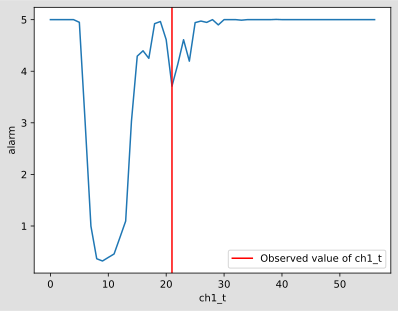

In [112]:
f_id = 11
obs = {nodes[i]:int(data_bn[f_id,51,i]) for i in range(9)}
# print('Observation:',obs)
print(f"MLP on training data. Alarm Channel={train_labels[f_id]}")
print(f"Observed values:{obs}")
print(evaluate_path_likelihoods(bn2, G, data_bn[f_id,51,:], nodes, {'fail_event':'alarm'}))
plot_cf_impact_on_trg(cm_bn1, obs, 'ch1_t', 'alarm')
print("End")


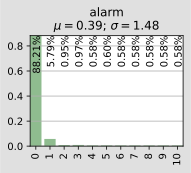

In [113]:
pot1 = do_counterfactual(cm_bn1, obs, "ch1_t", 10, "alarm")
gnb.showProba(pot1)

#### Test Case 2: 

Failure Index 3

MLP on training data. Alarm Channel=3
Observed values:{'alarm': 2, 'ch1_t': 8, 'ch2_t': 10, 'ch3_t': 24, 'ch1_t1': 12, 'ch2_t1': 9, 'ch3_t1': 12, 'ch1_t2': 7, 'ch3_t2': 7}
{'paths': [['ch2_t1', 'ch3_t', 'alarm'], ['ch2_t1', 'ch1_t', 'alarm'], ['ch1_t2', 'ch3_t', 'alarm'], ['ch3_t2', 'ch1_t', 'alarm'], ['ch3_t1', 'ch2_t', 'alarm'], ['ch1_t1', 'ch2_t', 'alarm']], 'probs': [0.0022, 0.0019, 0.0012, 0.0012, 0.0004, 0.0004]}


array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        , 19.        ,
        20.        , 21.        , 22.        , 23.        , 24.        ,
        25.        , 26.        , 27.        , 28.        , 29.        ,
        30.        , 31.        , 32.        , 33.        , 34.        ,
        35.        , 36.        , 37.        , 38.        , 39.        ,
        40.        , 41.        , 42.        , 43.        , 44.        ,
        45.        , 46.        , 47.        , 48.        , 49.        ,
        50.        , 51.        , 52.        , 53.        , 54.        ,
        55.        , 56.        ],
       [ 5.        ,  5.        ,  5.        ,  5.        ,  4.78947628,
         3.3103274 ,  1.2930278 ,  1.07986002,  0.95738653,  0.96692545,
         0.94639

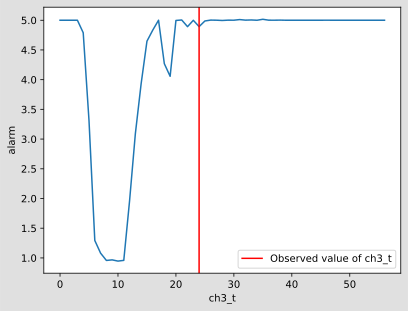

In [114]:
f_id = 3
obs = {nodes[i]:int(data_bn[f_id,51,i]) for i in range(9)}
print(f"MLP on training data. Alarm Channel={train_labels[f_id]}")
print(f"Observed values:{obs}")
print(evaluate_path_likelihoods(bn2, G, data_bn[f_id,50,:], nodes, {'fail_event':'alarm'}))
plot_cf_impact_on_trg(cm_bn1, obs, 'ch3_t', 'alarm')

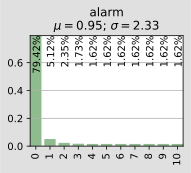

In [115]:
pot1 = do_counterfactual(cm_bn1, obs, "ch3_t", 10, "alarm")
gnb.showProba(pot1)

## Testing Set
### Test Case

MLP on training data. Alarm Channel=1
Observed values:{'alarm': 1, 'ch1_t': 17, 'ch2_t': 9, 'ch3_t': 8, 'ch1_t1': 9, 'ch2_t1': 7, 'ch3_t1': 8, 'ch1_t2': 7, 'ch3_t2': 9}
{'paths': [['ch2_t1', 'ch1_t', 'alarm'], ['ch1_t2', 'ch3_t', 'alarm'], ['ch2_t1', 'ch3_t', 'alarm'], ['ch3_t2', 'ch1_t', 'alarm'], ['ch3_t1', 'ch2_t', 'alarm'], ['ch1_t1', 'ch2_t', 'alarm']], 'probs': [0.089, 0.0462, 0.0454, 0.0276, 0.0234, 0.0048]}


array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        , 19.        ,
        20.        , 21.        , 22.        , 23.        , 24.        ,
        25.        , 26.        , 27.        , 28.        , 29.        ,
        30.        , 31.        , 32.        , 33.        , 34.        ,
        35.        , 36.        , 37.        , 38.        , 39.        ,
        40.        , 41.        , 42.        , 43.        , 44.        ,
        45.        , 46.        , 47.        , 48.        , 49.        ,
        50.        , 51.        , 52.        , 53.        , 54.        ,
        55.        , 56.        ],
       [ 5.        ,  5.        ,  5.        ,  5.        ,  5.        ,
         3.84043219,  1.4439246 ,  0.85235428,  0.61294071,  0.60759255,
         0.31878

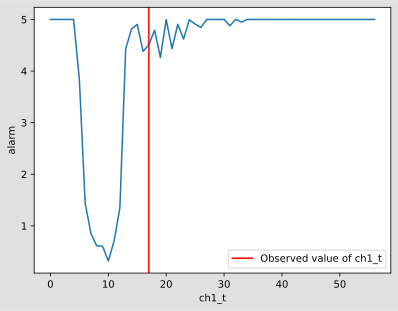

In [116]:
f_id = 10
obs = {nodes[i]:int(test_data_bn[f_id,51,i]) for i in range(9)}
# print('Observation:',obs)
print(f"MLP on training data. Alarm Channel={test_labels[f_id]}")
print(f"Observed values:{obs}")
print(evaluate_path_likelihoods(bn2, G, test_data_bn[f_id,50,:], nodes, {'fail_event':'alarm'}))
plot_cf_impact_on_trg(cm_bn1, obs, 'ch1_t', 'alarm')


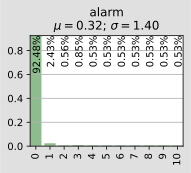

In [117]:
pot1 = do_counterfactual(cm_bn1, obs, "ch1_t", 10, "alarm")
gnb.showProba(pot1)

In [118]:
# pot=csl.counterfactual(cm =cm_bn1,
#                 profile={'alarm': 2, 'ch1_t': 8, 'ch2_t': 10, 'ch3_t': 24, 'ch1_t1': 12, 'ch2_t1': 9, 'ch3_t1': 12, 'ch1_t2': 7, 'ch3_t2': 7},
#                 # profile = {'alarm': 2, 'ch1_t': 9, 'ch2_t': 24, 'ch3_t': 10, 'ch1_t1': 7, 'ch2_t1': 9, 'ch3_t1': 8, 'ch1_t2': 9, 'ch3_t2': 9}, 
#                 whatif={'ch2_t'},
#                 on={'alarm'},
#                 values = {'ch2_t' : 23})

# Export results

In [119]:
id = 11

In [120]:
def plt_cf_exp_sd_impact_on_trg(cm, obs, cf_var, trg):
    bn= cm.observationalBN()
    domain = list(map(int, bn.variable(cf_var).domain()[1:-1].split(',')))
    dom = [*range(domain[0],domain[1]+1)]
    exval_trg = list()
    sd_trg = list()
    for i in dom:
        pot1 = do_counterfactual(cm, obs, cf_var, i, trg)
        # print((pot1.toarray()))
        exp = pot1.expectedValue(lambda v : bn.variable(trg).numerical(v[trg]))
        # print('E[x]=',exp)
        x = np.arange(11)
        # tmp = np.sum(np.dot(np.square((x - exp)), pot1.toarray()))
        # print('sd_alt = ' , tmp**0.5)
        sd = (np.dot(np.square(x),pot1.tolist()) - exp**2)**0.5
        # print('sd=',sd)
        exval_trg.append(exp)
        sd_trg.append(sd)

        

    plt.plot(dom,exval_trg, label=f"Expected value")
    plt.plot(dom,sd_trg,label="Standard Deviation")
    plt.xlabel(cf_var)
    plt.ylabel(trg)
    plt.axvline(obs[cf_var],color='r', label=f"Observed value of {cf_var }")
    plt.legend(loc='best')
    return np.array([dom, exval_trg, sd_trg])

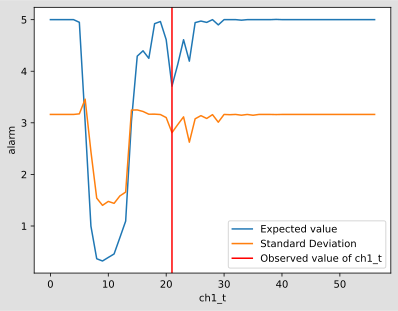

In [121]:
# description
desc = """
    raw_data (np.array): 100 x 4 Data Generated from the source 
    fchannel (int): Faulty Channel 
    columns : column names
    alarm_pred (list): Predicted alarm values
    mlp (dict): Most likely paths leading to failure (paths (list), probs (list))
    cf_var (str) : Counterfactual variable
    cf_data (np.array): 3 x domain_size (domain, exp_value, sd)
    """
# raw data
raw_data = train_data[id]
# faulty channel
fchannel = train_labels[id]
# Columns
columns = nodes[:4]
# Alarm Prediction data
alarm_pred = train_alarm_pred[id]
# Most Likely path
path_probs = evaluate_path_likelihoods(bn2, G, data_bn[id,50,:], nodes, {'fail_event':'alarm'})
mlp = path_probs
# {
#     "path":path_probs['paths'],
#     "prob":path_probs['probs']
# }
# Counterfactual
cf_var = mlp['paths'][0][-2]
# Counterfactual data
obs = {nodes[i]:int(data_bn[id,51,i]) for i in range(9)}
cf_data = plt_cf_exp_sd_impact_on_trg(cm_bn1, obs, cf_var, 'alarm')


In [122]:
data_export = {
    'description': desc,
    'raw_data': raw_data,
    'fchannel': fchannel,
    'columns':columns,
    'alarm_pred': alarm_pred,
    'mlp':mlp,
    'cf_var':cf_var,
    'cf_data': cf_data
}

In [123]:
import pickle
pickle.dump(data_export, open('data_export.pkl', 'wb')) 

In [124]:
dat = pickle.load(open('data_export.pkl', 'rb'))

In [125]:
print(dat['description'])


    raw_data (np.array): 100 x 4 Data Generated from the source 
    fchannel (int): Faulty Channel 
    columns : column names
    alarm_pred (list): Predicted alarm values
    mlp (dict): Most likely paths leading to failure (paths (list), probs (list))
    cf_var (str) : Counterfactual variable
    cf_data (np.array): 3 x domain_size (domain, exp_value, sd)
    


# Test Area

In [ ]:
# !pip install sympy
import sympy as sym

In [ ]:
x = sym.Symbol('x')
y = sym.Symbol('y')

# y = x**3 - 2*x**2 + 8*x
y=x**4 -24*x**2 + 11

y

x**4 - 24*x**2 + 11

In [ ]:
dy = sym.diff(y,x)
ddy = sym.diff(dy,x)
# dy,ddy

In [ ]:
t = np.linspace(-5,5,50)
y_g =[y.evalf(subs={x:k}) for k in t]
dy_g =[dy.evalf(subs={x:k}) for k in t]
ddy_g =[ddy.evalf(subs={x:k}) for k in t]

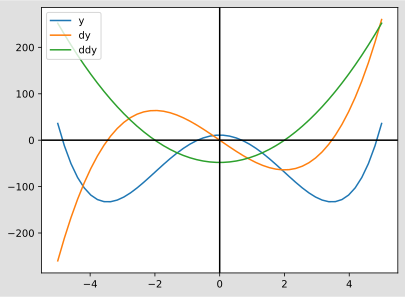

In [ ]:
plt.plot(t,y_g,label='y')
plt.plot(t,dy_g,label='dy')
plt.plot(t,ddy_g,label='ddy')
plt.legend(loc='upper left')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

In [ ]:
sym.solveset(dy,x)

{0, -2*sqrt(3), 2*sqrt(3)}

In [ ]:
sym.solveset(ddy,x)

{-2, 2}

In [ ]:
2*np.sqrt(3)

3.4641016151377544

In [ ]:
# np.where(ddy_g==np.max(ddy_g))
t[np.argmax(ddy_g)]

-5.0

In [ ]:
prob_df.value_counts()

NameError: name 'prob_df' is not defined

In [ ]:
fail_probs[np.where(fail_probs[:,2]>0.5)[0], 2]

array([0.99999071, 0.99999071])